In [1]:
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df = pd.read_csv('gdrive/MyDrive/A_Z Handwritten Data.csv')
df.tail()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617,0.618,0.619,0.620,0.621,0.622,0.623,0.624,0.625,0.626,0.627,0.628,0.629,0.630,0.631,0.632,0.633,0.634,0.635,0.636,0.637,0.638,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
372445,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
372446,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
372447,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
372448,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
372449,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.astype('float32')
df.rename(columns={'0':'label'}, inplace=True)
X = df.drop('label',axis = 1).values
y = df['label'].values
del df

In [6]:
alphabets="abcdefghijklmnopqrstuvwxyz"
letter_name=[]
[letter_name.append(i) for i in alphabets]
name_tag = pd.DataFrame(letter_name)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


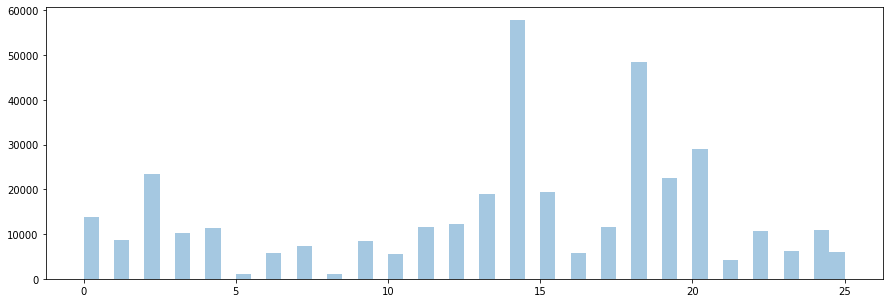

In [7]:
plt.figure(figsize=(15,5))
sns.distplot(y,kde=False)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
data_augmentation = tf.keras.Sequential([
  preprocessing.RandomRotation(0.1, interpolation='nearest'),
  preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2, interpolation='nearest'),
])

In [10]:
x_rotated = data_augmentation(x_train.reshape(x_train.shape[0],28,28,1))

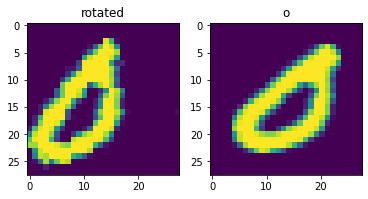

In [11]:
index = random.randint(0, (x_test.shape[0] - 1))
f, arr = plt.subplots(1,2)
arr[0].title.set_text('rotated')
arr[0].imshow(x_rotated[index].numpy().reshape(28,28))
arr[1].title.set_text(alphabets[y_train[index]])
arr[1].imshow(x_train[index].reshape(28,28))
plt.show()

In [12]:
x_rotated = x_rotated.numpy().reshape(x_rotated.shape[0], x_rotated.shape[1],x_rotated.shape[2])
x_rotated.shape

(249541, 28, 28)

In [13]:
# randomly select n rotated images from x_rotated
n = 10000
i = [np.random.choice(x_rotated.shape[0], size=n, replace=False)]
x_selected = x_rotated[tuple(i)]
y_selected = y_train[tuple(i)]
x_selected.shape

(10000, 28, 28)

In [14]:
x_train = x_train.reshape(x_train.shape[0], 28, 28)
x_test = x_test.reshape(x_test.shape[0], 28, 28)
x_train.shape

(249541, 28, 28)

In [15]:
x_train = np.concatenate((x_train, x_selected), axis=0)
y_train = np.concatenate((y_train, y_selected), axis=0)
x_train.shape

(259541, 28, 28)

Model 1 - Dense Model

In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape =(x_train.shape[1], x_train.shape[2])),
  tf.keras.layers.Dense(500, activation='swish'),
  tf.keras.layers.Dense(250, activation='swish'),
  tf.keras.layers.Dense(125, activation='swish'),
  tf.keras.layers.Dense(26, activation='sigmoid')
])

Model 2 - Conv Model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(28,(3,3), activation='relu', input_shape=(28,28,1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(56,(3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(56,(3,3), activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(56, activation='relu'),
  tf.keras.layers.Dense(26, activation=None)
])

In [17]:
# reshaping for model fitting
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2], 1)
x_test=x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_train.shape

(259541, 28, 28, 1)

In [18]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


8100/8111 [============================>.] - ETA: 0s - loss: 0.6730 - accuracy: 0.8525

In [ ]:
# plot accuracy and loss
plt.subplot(211)
plt.title('Loss')
plt.plot(r.history['loss'], label='train')
plt.plot(r.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(r.history['accuracy'], label='train')
plt.plot(r.history['val_accuracy'], label='test')
plt.legend()
plt.show()